In [1]:
import os, sys
import os.path as osp
root_dir = osp.dirname(osp.dirname(osp.dirname(os.getcwd())))
sys.path.append(osp.join(root_dir, 'src'))

from ml_modules.data import deepstabp_col, processed_dir

import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

src_dir = osp.join(processed_dir, 'v1-prot_bert_bfd')

In [3]:
prefix = 'cell-human'

filename = f'{prefix}.csv'
file_path = osp.join(deepstabp_col, filename)
accessions = np.loadtxt(
    file_path, usecols=0, skiprows=1, dtype=np.str_, delimiter=','
)

print(accessions)
print(accessions.shape)

['A0A3B3IS91' 'A0AV96' 'A0AVF1' ... 'R4GMY8' 'R4GN35' 'R4GNH3']
(9014,)


In [6]:
### COMPARE ACCESSIONS IN META FILE

all_pLDDTs = []
all_residues = torch.zeros(1, 1024, dtype=torch.float64)

success_count = 0
error_count = 0

pbar = tqdm(accessions)
for accession in pbar:
    pbar.set_description(accession)

    data_path = osp.join(src_dir, f'{accession}-AFv4.pt')

    if not osp.exists(data_path):
        error_count += 1
        continue
    else:
        success_count += 1

    data = torch.load(data_path)
    
    all_pLDDTs += data['residue'].pLDDT.tolist()
    all_residues += torch.sum(data['residue'].x, dim=0)

all_pLDDTs = np.array(all_pLDDTs)
all_residues = all_residues.numpy()

print(all_pLDDTs.shape)
print(all_residues.shape)
print(f'success_count: {success_count}')
print(f'failed_count: {error_count}')

  0%|          | 0/9014 [00:00<?, ?it/s]

(1949838,)
(1, 1024)
success_count: 5666
failed_count: 3348


In [5]:
### COMPARE ALL PROCESSED FILES

all_pLDDTs = []
all_residues = torch.zeros(1, 1024, dtype=torch.float64)

pbar = tqdm([f for f in os.listdir(src_dir)
             if f.endswith('.pt') and not f.startswith('pre_')])
for i, f in enumerate(pbar):
    accession = f[:-3]
    pbar.set_description(accession)

    data_path = osp.join(src_dir, f)
    data = torch.load(data_path)
    
    all_pLDDTs += data['residue'].pLDDT.tolist()
    all_residues += torch.sum(data['residue'].x, dim=0)

all_pLDDTs = np.array(all_pLDDTs)
all_residues = all_residues.numpy()

print(all_pLDDTs.shape)
print(all_residues.shape)

  0%|          | 0/8829 [00:00<?, ?it/s]

(2926529,)
(1, 1024)


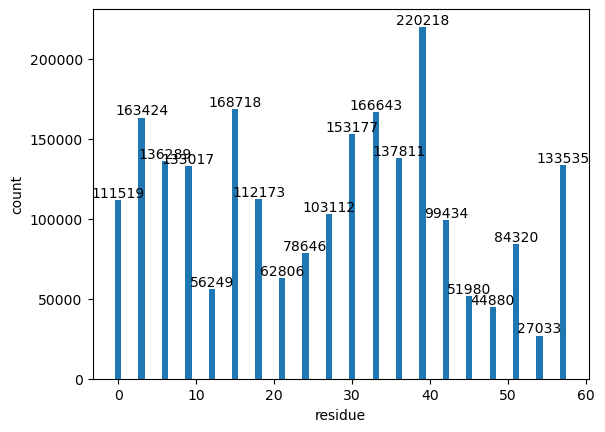

In [ ]:
fig, ax = plt.subplots()
bar_container = ax.bar(np.arange(20)*3, all_residues.squeeze())
ax.bar_label(bar_container, fmt='%d')
ax.set_xlabel('residue')
ax.set_ylabel('count')
plt.show()
plt.close()

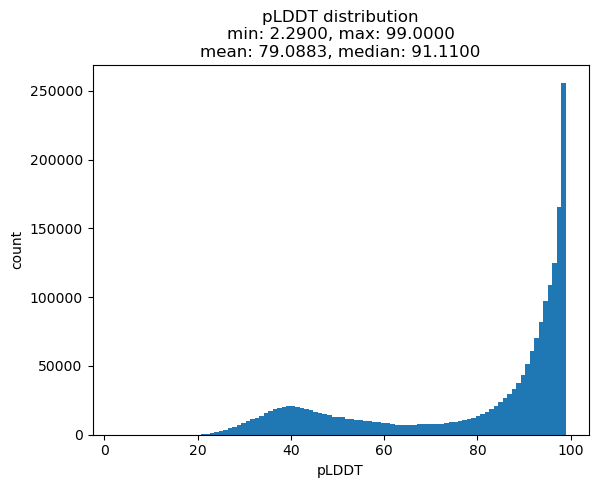

In [7]:
values = all_pLDDTs

amin = np.amin(values)
amax = np.amax(values)
mean = np.mean(values)
median = np.median(values)

plt.hist(values, bins=100)
plt.title(
    f'pLDDT distribution\n'
    f'min: {amin:.4f}, max: {amax:.4f}\n'
    f'mean: {mean:.4f}, median: {median:.4f}'
)
plt.xlabel('pLDDT')
plt.ylabel('count')
plt.show()
# plt.savefig('pLDDT.png', dpi=300, bbox_inches='tight')
plt.close()